In [1]:
%pylab inline

import numpy as np
import itertools
import random

Populating the interactive namespace from numpy and matplotlib


# Mancala

Mancala is a ancient family of games played played on many continents ([source, page 2623](https://doi.org/10.1007/978-94-007-3934-5_9947-1)). The word *mancala* comes from the Arabic word *نقل* transliterated *naqala* meaning literally "to move".

Mancala games usualy consists of two row of pits each containing a proportionaite amount of seeds, stones or shells.
Usualy, these games are played by two opponents who play sequentialy.

The goal for each opponent is to capture as many seeds as possible before the other.

-- Insert figure here

We will focus on Awalé (also called Oware or Owari), originating from Ghana and Kalah, a modern version invented by William Julius Champion Jr. circa 1940.

There are too many other existing variations to list them all here, but a few notable ones are Wari, Bao and Congkak.


## Perfect information

Mancala games are : 
 * sequential : the oppenents play one after the other,
 * hold no secret information : each playser has the same information about the game as the other
 * do not rely on randomness : the state of the game depends only on the actions taken sequentialy by each player and an action has a determinitc result.

This type of game is called a sequential perfect information game. ([6.1 page 89](http://ebour.com.ar/pdfs/A%20Course%20in%20Game%20Theory.pdf)).

-- Insert something about finite state machines ?

Other games in this category are for example Chess, Go, Checkers or even Tic-tac-toe and Connect Four.

This type of game is a particularly intersting field to study in computer science and artifical intelligence as they are easy to simulate.

While it might be tempting to enumerate every possible play of those games by starting a game and recusively try each legal action untill the end of the play, most of the time, this is not a feasible approch for most games due to the size of the state space.

For example, [Romein et al.](https://www.cs.vu.nl/pub/bal/awari.ps) claims that Awalé has 889,063,398,406 legal positions and the number of $\approx 2.08 * 10^170$ legal postions in Go has only [recently been determined](http://tromp.github.io/go/legal.html).

[Kalah is solved](http://kalaha.krus.dk/) 

## Oware

The b

# Awalé
Also known as awari and owari

## Solved

It might be solved by [Solving awari with parallel retrograde analysis](http://ieeexplore.ieee.org/abstract/document/1236468/)

In [2]:
class Game:
    def __init__(self, pits=6, seeds=4):
        self.pits = pits
        self.seeds = seeds
        self.reset()
        self.actions = np.array(range(self.pits))
    
    def reset(self):
        self.state = np.ones((self.pits * 2), dtype=int) * self.seeds
        self.current_player = 0
        self.captures = np.zeros((2,), dtype=int)
        self.history = set()
    
    def copy(self):
        g = Game()
        
        g.state = self.state.copy()
        g.current_player = self.current_player
        g.captures = self.captures.copy()
        g.history = self.history.copy()
        
        return g
    
    @property
    def state_from_current_player(self):
        shift = 0 if self.current_player == 0 else self.pits
        return np.roll(self.state, shift)

    @property
    def legal_actions(self):
        # todo : add the Let the opponent play rule
        return [x for x in range(self.pits) if self.state[x] != 0]


    def step(self, action):
        assert 0 <= action < self.pits
        action = action if self.current_player == 0 else action - self.pits
        
        seeds = self.state[action]
        assert seeds != 0
        
        # empty the target pit
        self.state[action] = 0
        
        # fill the next pits
        pit_to_sow = action
        while seeds > 0:
            pit_to_sow = (pit_to_sow + 1) % (self.pits * 2)
            if pit_to_sow != action: # do not fill the target pit ever
                self.state[pit_to_sow] += 1
                seeds -= 1
        
        # capture
        # count the captures of the play
        captures = 0
        if pit_to_sow in self.adverse_pits_idx:
            # if the last seed was in a adverse pit
            # we can try to collect seeds
            while self.state[pit_to_sow] in (2, 3):
                # if the pit contains 2 or 3 seeds, we capture them
                self.captures[self.current_player] += self.state[pit_to_sow]
                captures += self.state[pit_to_sow]
                self.state[pit_to_sow] = 0
                
                # go backwards
                pit_to_sow = (pit_to_sow - 1) % (self.pits * 2)
                
        
        # change player
        self.current_player = (self.current_player + 1) % 2
        
        # record state
        tstate = tuple(self.state)
        if tstate in self.history:
            assert False, "Game loop"
        else:
            self.history.add(tstate)
        
        return captures, self.state, self.game_finished
    
    @property
    def adverse_pits_idx(self):
        if self.current_player == 1:
            return list(range(self.pits))
        else:
            return list(range(self.pits, self.pits * 2))
    
    @property
    def game_finished(self):
        no_moves_left = np.all(self.state_from_current_player[:self.pits] == np.zeros((self.pits,)))
        enough_captures = np.any(self.captures > (self.pits * self.seeds) / 2)
        draw = np.all(self.captures == (self.pits * self.seeds) / 2)
        loop = tuple(self.state) in self.history
        return no_moves_left or enough_captures or draw or loop
    
    def show_state(self):
        if self.game_finished:
            print("Game finished")
        print("Current player: {} - Score: {}/{}\n{}".format(
            self.current_player,
            self.captures[self.current_player],
            self.captures[(self.current_player + 1) % 2],
            "-" * self.pits * 3
        ))
        
        pits = []
        for seeds in self.state_from_current_player:
            pits.append("{:3}".format(seeds))
        
        print("".join(reversed(pits[self.pits:])))
        print("".join(pits[:self.pits]))
        
        

Shortest game ever recoreded according to [Mancala World](http://mancala.wikia.com/wiki/Oware) : 19 steps

In [3]:
g = Game()

In [4]:
#%%timeit

g.reset()
shortest_game = [(6, 0), (6, 0), (3, 0), (5, 0), (3, 0), (6, 0), (2, 0), (4, 2), (4, 4), (4, 0), (2, 0), (5, 0), (3, 0), (3, 0), (5, 7), (1, 6), (1, 7), (2, 0), (6, 9),]

for action, captures in shortest_game:
    game_captures, _, _ = g.step(action - 1)
    assert captures == game_captures
g.show_state()

Game finished
Current player: 1 - Score: 8/27
------------------
  0  2  2  2  2  1
  3  1  0  0  0  0


# Tree Search

In [5]:
from recordclass import recordclass

GAME_NODE_FIELDS = ['n_pits', 'seeds_per_pit', 'pits', 'current_player', 'captures', 'parent', 'children', 'wins', 'n_playouts']
        
class Game(recordclass('GameNode', GAME_NODE_FIELDS)):
    @classmethod
    def start_game(klass, n_pits=6, seeds_per_pit=4):
        return klass(
            n_pits,
            seeds_per_pit,
            pits=np.ones((n_pits * 2), dtype=int) * seeds_per_pit,
            current_player=0,
            captures=np.zeros((2,), dtype=int),
            parent=None,
            children=[None] * n_pits,
            wins=0,
            n_playouts=0
        )
    
    @property
    def view_from_current_player(self):
        shift = 0 if self.current_player == 0 else self.n_pits
        return np.roll(self.pits, shift)

    @property
    def legal_actions(self):
        # todo : add the Let the opponent play rule
        player_view = self.view_from_current_player
        return [x for x in range(self.n_pits) if player_view[x] != 0]
    
    @property
    def successors(self):
        children = [x for x in self.children if x is not None]
        successors = children + list(itertools.chain(*[x.successors for x in children]))
        return successors

    def step(self, action):
        assert 0 <= action < self.n_pits
        
        if self.children[action] is not None:
            new_game = self.children[action]
            captures = self.captures[self.current_player] - new_game.captures[self.current_player]
            return new_game, captures, new_game.game_finished
        
        target_pit = action if self.current_player == 0 else action - self.n_pits
        
        seeds = self.pits[target_pit]
        assert seeds != 0
        
        # copy attributes
        pits = np.copy(self.pits)
        captures = np.copy(self.captures)
        
        # empty the target pit
        pits[target_pit] = 0
        
        # fill the next pits
        pit_to_sow = target_pit
        while seeds > 0:
            pit_to_sow = (pit_to_sow + 1) % (self.n_pits * 2)
            if pit_to_sow != target_pit: # do not fill the target pit ever
                pits[pit_to_sow] += 1
                seeds -= 1
        
        # capture
        # count the captures of the play
        round_captures = 0
        if pit_to_sow in self.adverse_pits_idx:
            # if the last seed was in a adverse pit
            # we can try to collect seeds
            while pits[pit_to_sow] in (2, 3):
                # if the pit contains 2 or 3 seeds, we capture them
                captures[self.current_player] += pits[pit_to_sow]
                round_captures += pits[pit_to_sow]
                pits[pit_to_sow] = 0
                
                # go backwards
                pit_to_sow = (pit_to_sow - 1) % (self.n_pits * 2)
        
        # change player
        current_player = (self.current_player + 1) % 2
        
        new_game = type(self)(
            self.n_pits,
            self.seeds_per_pit,
            pits,
            current_player,
            captures,
            self,
            [None] * self.n_pits,
            0,
            0
        )
        
        self.children[action] = new_game
        return new_game, round_captures, new_game.game_finished
    
    @property
    def adverse_pits_idx(self):
        if self.current_player == 1:
            return list(range(self.n_pits))
        else:
            return list(range(self.n_pits, self.n_pits * 2))
    
    @property
    def is_state_loop(self):
        ancestor = self.parent
        while ancestor is not None:
            if np.all(ancestor.pits == self.pits):
                return True
            ancestor = ancestor.parent
        return False
    
    @property
    def game_finished(self):
        no_moves_left = np.all(self.view_from_current_player[:self.n_pits] == np.zeros((self.n_pits,)))
        enough_captures = np.any(self.captures > (self.n_pits * self.seeds_per_pit) / 2)
        draw = np.all(self.captures == (self.n_pits * self.seeds_per_pit) / 2)
        loop = self.is_state_loop
        return no_moves_left or enough_captures or draw or loop
    
    def show_state(self):
        if self.game_finished:
            print("Game finished")
        print("Current player: {} - Score: {}/{}\n{}".format(
            self.current_player,
            self.captures[self.current_player],
            self.captures[(self.current_player + 1) % 2],
            "-" * self.n_pits * 3
        ))
        
        pits = []
        for seeds in self.view_from_current_player:
            pits.append("{:3}".format(seeds))
        
        print("".join(reversed(pits[self.n_pits:])))
        print("".join(pits[:self.n_pits]))
    
    def update_stats(self, win):
        self.wins += int(win)
        self.n_playouts += 1
        if self.parent:
            self.parent.update_stats(win)
    
    @property
    def winner(self):
        if not self.game_finished:
            return None
        return np.argmax(self.captures)
    
    @property
    def unvisited_actions(self):
        return [i for i, x in enumerate(self.children) if x is None]

    @property
    def legal_unvisited_actions(self):
        return list(set(self.unvisited_actions).intersection(set(self.legal_actions)))
    
    @property
    def expanded_children(self):
        return [x for x in self.children if x is not None]
    
    @property
    def is_fully_expanded(self):
        legal_actions = set(self.legal_actions)
        unvisited_actions = set(self.unvisited_actions)
        return len(legal_actions.intersection(unvisited_actions)) == 0
    
    @property
    def is_leaf_game(self):
        return self.children == [None] * self.n_pits
    
    @property
    def depth(self):
        if self.parent is None:
            return 0
        return 1 + self.parent.depth
    
    def to_dot(self, is_root=True):
        output = "%s -> %s;\n" % (id(self.parent), id(self)) if self.parent else "\n"
        output += '%s [label="%s/%s"]' % (id(self), self.wins, self.n_playouts)
        
        for child in self.children:
            if child is not None:
                output += child.to_dot(False) + "\n"
        
        if is_root:
            return """
            digraph BST {
                node [fontname="Arial"];
                %s
            }
            """ % output
        
        return output
    
    def __repr__(self):
        return "<Game {wins}/{n_playouts} player:{player} captures:{captures[0]}/{captures[1]}>".format(
            wins=self.wins,
            n_playouts=self.n_playouts,
            player=self.current_player,
            captures=self.captures
        )
        
        

In [6]:
g = Game.start_game(1, 2)

g, _, _ = g.step(0)
g, captues, done = g.step(0)
assert done


# MCTS

In [7]:
def random_tree_policy(root):
    nodes = [root] + root.successors
    unexpanded_nodes = [n for n in nodes if not n.is_fully_expanded]
    return random.choice(unexpanded_nodes)

def random_default_policy(node):
    if node.is_fully_expanded:
        return random.choice(node.legal_actions)
    return random.choice(node.legal_unvisited_actions)

def mcts(budget, tree_policy, default_policy):
    # Create a tree
    root = Game.start_game()

    for _ in range(budget):
        # Choose a starting node
        node = tree_policy(root)
        
        # Run a simulation on that node
        finished = node.game_finished
        while not finished:
            node, _, finished = node.step(default_policy(node))
        
        # Backtrack stats
        win = (node.winner == 0)
        node.update_stats(win)
    
    return root

# MCTS + UCB

In [16]:
def max_rand(iterable, key=lambda x: x):
    maximum_value = max(key(x) for x in iterable)
    keep = [x for x in iterable if key(x) == maximum_value]
    return random.choice(keep)

def UCT_best_child(node):
    def score(node):
        assert node is not None
        c = 1 / math.sqrt(2)
        exporation = node.wins / node.n_playouts
        exploitation = math.sqrt(math.log(node.parent.n_playouts) / node.n_playouts)
        return exporation + c * exploitation
    
    return max_rand(node.expanded_children, key=score)

def UCT_tree_policy(root):
    node = root
    while not node.is_leaf_game:
        if node.is_fully_expanded:
            node = UCT_best_child(node)
        else:
            action = random.choice(node.legal_unvisited_actions)
            node, _, _ = node.step(action)
    return node

def UCT_default_policy(node):
    return random.choice(node.legal_unvisited_actions)

## Compare

In [21]:
%%time
BUDGET = 100
root = mcts(BUDGET, random_tree_policy, random_default_policy)
root2 = mcts(BUDGET, UCT_tree_policy, UCT_default_policy)

CPU times: user 3.64 s, sys: 3.97 ms, total: 3.64 s
Wall time: 3.69 s


In [22]:
with open("dot", 'w') as fd:
    fd.write(root.to_dot())

with open("dot2", 'w') as fd:
    fd.write(root2.to_dot())

<Game 453/1000 player:0 captures:0/0> 148
126
528.3163458680142


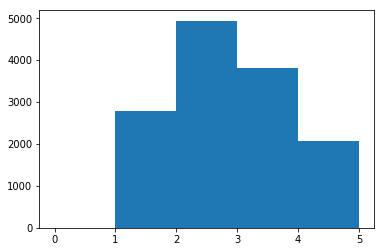

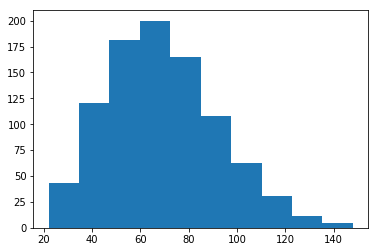

In [19]:
print(root, max([x.depth for x in root.successors]))
leaf_depths = [x.depth for x in root.successors if x.is_leaf_game]
print(max(leaf_depths) - min(leaf_depths))
print(np.var(leaf_depths))
plt.hist([6 - len(x.legal_unvisited_actions) for x in root.successors], bins=range(6));
plt.show()
plt.hist([x.depth for x in root.successors if x.is_leaf_game]);

<Game 513/1000 player:0 captures:0/0> 122
112
357.163804


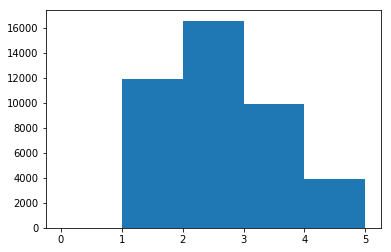

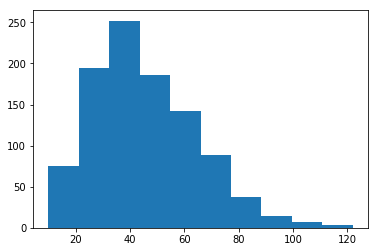

In [20]:
print(root2, max([x.depth for x in root2.successors]))
leaf_depths = [x.depth for x in root2.successors if x.is_leaf_game]
print(max(leaf_depths) - min(leaf_depths))
print(np.var(leaf_depths))
plt.hist([6 - len(x.legal_unvisited_actions) for x in root2.successors], bins=range(6));
plt.show()
plt.hist([x.depth for x in root2.successors if x.is_leaf_game]);

# Learning

# Deep mind

 * Alpha Go [Mastering the game of Go with deep neural networks and tree search](https://storage.googleapis.com/deepmind-media/alphago/AlphaGoNaturePaper.pdf)
 * Alpha Go Zero [Mastering the game of Go without human knowledge](https://www.nature.com/articles/nature24270.epdf?author_access_token=VJXbVjaSHxFoctQQ4p2k4tRgN0jAjWel9jnR3ZoTv0PVW4gB86EEpGqTRDtpIz-2rmo8-KG06gqVobU5NSCFeHILHcVFUeMsbvwS-lxjqQGg98faovwjxeTUgZAUMnRQ)
 * Alpha Zero [Mastering Chess and Shogi by Self-Play with a
General Reinforcement Learning Algorithm](https://arxiv.org/pdf/1712.01815.pdf)